In [1]:
import matplotlib.pyplot as plt
import numpy as np

import DissimilarityMetrics
import ChannelChartingCore
import Evaluation

2024-10-11 14:06:57.585248: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-11 14:06:58.531508: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# This may take some time
import dichasus_cf0x

2024-10-11 14:07:00.315395: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-10-11 14:07:00.358508: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-10-11 14:07:00.358889: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [3]:
# Remove CSI from all antenna arrays except array
b=2
# Note that sampling time offset normalization may still lead to a contribution by the other antenna arrays.
# That is, even though we removed CSI from the other two arrays, the time of arrival observed from the CSI
# of this one antenna array may be impacted by the other two arrays.
# Re-normalizing the sampling time offset would account for this and may reduce performance somewhat.
# Whether or not this case is realistic depends on the considered application.
csi_time_domain_onearray = dichasus_cf0x.csi_time_domain[:,b-1][:,np.newaxis]

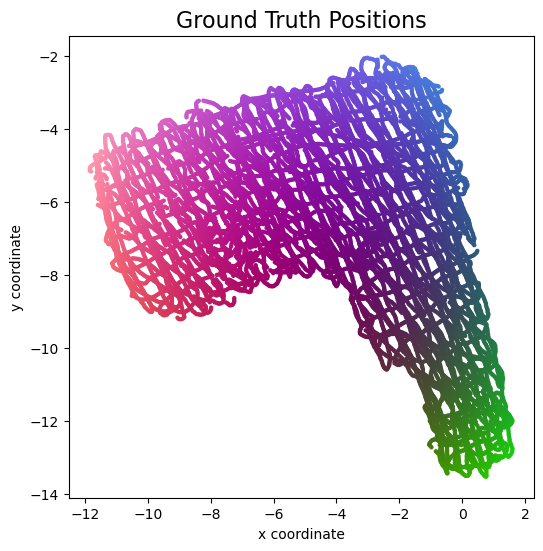

In [4]:
Evaluation.plot_colorized(dichasus_cf0x.groundtruth_positions, dichasus_cf0x.groundtruth_positions, title="Ground Truth Positions")

In [5]:
def mean_variance_from_delta_adp(delta_adp):
    mean = np.where(delta_adp < 1, 0,
           np.where(np.logical_and(delta_adp >= 1, delta_adp < 3), 0.01 * delta_adp + 0.01, 
           #np.where(np.logical_and(delta_adp >= 4, delta_adp < 5), 0.01 * delta_adp + 0.01,
           np.where(delta_adp > 3, np.inf, np.nan)))

    variance = np.where(delta_adp < 1, 0.0001,
       np.where(np.logical_and(delta_adp >= 1, delta_adp < 3), 0.0002 + 0.00005 * delta_adp, 
       #np.where(np.logical_and(delta_adp >= 4, delta_adp < 5), 0.0008,
       np.where(delta_adp > 3, 10000, np.nan)))

    return mean, variance

adp_metric = DissimilarityMetrics.ADPDissimilarityMetric(csi_time_domain_onearray, mean_variance_from_delta_adp)

In [6]:
import tensorflow as tf

@tf.function
def compute_adp_dissimilarity_matrix(csi_array):
	output = tf.TensorArray(tf.float32, size = csi_array.shape[0])

	powers = tf.einsum("lbmt,lbmt->lbt", csi_array, tf.math.conj(csi_array))
	for i in tf.range(csi_array.shape[0]):
		w = csi_array[i:,:,:,:]
		h = csi_array[i,:,:,:]

		dotproducts = tf.abs(tf.square(tf.einsum("bmt,lbmt->lbt", tf.math.conj(h), w)))
		d_new = tf.math.reduce_sum(1 - dotproducts / tf.math.real(powers[i] * powers[i:]), axis = (1, 2))
		d = tf.concat([tf.zeros(i), tf.maximum(d_new, 0)], 0)

		output = output.write(i, d)

	dissim_upper_tri = output.stack()

	return dissim_upper_tri + tf.transpose(dissim_upper_tri)

adp_matrix = compute_adp_dissimilarity_matrix(csi_time_domain_onearray).numpy()

In [7]:
print(adp_metric.adp_distance_mean)

[[0.         0.         0.03582016 ...        inf        inf        inf]
 [0.         0.                inf ...        inf        inf        inf]
 [0.03582016        inf 0.         ...        inf        inf        inf]
 ...
 [       inf        inf        inf ... 0.         0.         0.        ]
 [       inf        inf        inf ... 0.         0.         0.        ]
 [       inf        inf        inf ... 0.         0.         0.        ]]


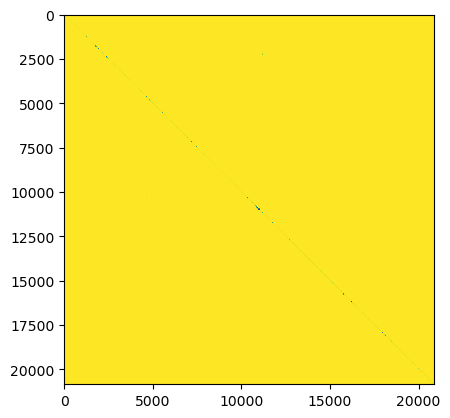

In [8]:
plt.imshow(np.where(adp_metric.adp_distance_mean != np.inf, adp_metric.adp_distance_mean, 100))
plt.show()

In [9]:
# For the single-antenna setup we assume a lower variance in the velocity model so that
# the channel charting algorithm relies more on velocity information.
velocity_mean = 0.235
velocity_variance = 0.0015

# Make worste-case assumption of perfectly correlated velocities. This maximizes the variance.
velocity_metric = DissimilarityMetrics.VelocityDissimilarityMetric(velocity_mean, velocity_variance, True, dichasus_cf0x.timestamps)

In [10]:
GDM = ChannelChartingCore.GaussianDissimilarityModel([adp_metric, velocity_metric], enable_path_contraction = False)
GDM.generate_short_paths(realization_count = 8)

  0%|          | 0/8 [00:00<?, ?it/s]

Generating dissimilarity realizations...


  0%|          | 0/2 [00:00<?, ?it/s]

Choosing smallest dissimilarity realization pair-wise...
Running shortest path algorithm...


Computing Shortest Paths:   0%|          | 0/104255000 [00:00<?, ?it/s]

Preparing Dijkstra Inputs:   0%|          | 0/5000 [00:00<?, ?it/s]

Starting Processes:   0%|          | 0/10 [00:00<?, ?it/s]

Generating dissimilarity realizations...


  0%|          | 0/2 [00:00<?, ?it/s]

Choosing smallest dissimilarity realization pair-wise...
Running shortest path algorithm...


Computing Shortest Paths:   0%|          | 0/104255000 [00:00<?, ?it/s]

Preparing Dijkstra Inputs:   0%|          | 0/5000 [00:00<?, ?it/s]

Starting Processes:   0%|          | 0/10 [00:00<?, ?it/s]

Generating dissimilarity realizations...


  0%|          | 0/2 [00:00<?, ?it/s]

Choosing smallest dissimilarity realization pair-wise...
Running shortest path algorithm...


Computing Shortest Paths:   0%|          | 0/104255000 [00:00<?, ?it/s]

Preparing Dijkstra Inputs:   0%|          | 0/5000 [00:00<?, ?it/s]

Starting Processes:   0%|          | 0/10 [00:00<?, ?it/s]

Generating dissimilarity realizations...


  0%|          | 0/2 [00:00<?, ?it/s]

Choosing smallest dissimilarity realization pair-wise...
Running shortest path algorithm...


Computing Shortest Paths:   0%|          | 0/104255000 [00:00<?, ?it/s]

Preparing Dijkstra Inputs:   0%|          | 0/5000 [00:00<?, ?it/s]

Starting Processes:   0%|          | 0/10 [00:00<?, ?it/s]

Generating dissimilarity realizations...


  0%|          | 0/2 [00:00<?, ?it/s]

Choosing smallest dissimilarity realization pair-wise...
Running shortest path algorithm...


Computing Shortest Paths:   0%|          | 0/104255000 [00:00<?, ?it/s]

Preparing Dijkstra Inputs:   0%|          | 0/5000 [00:00<?, ?it/s]

Starting Processes:   0%|          | 0/10 [00:00<?, ?it/s]

Generating dissimilarity realizations...


  0%|          | 0/2 [00:00<?, ?it/s]

Choosing smallest dissimilarity realization pair-wise...
Running shortest path algorithm...


Computing Shortest Paths:   0%|          | 0/104255000 [00:00<?, ?it/s]

Preparing Dijkstra Inputs:   0%|          | 0/5000 [00:00<?, ?it/s]

Starting Processes:   0%|          | 0/10 [00:00<?, ?it/s]

Generating dissimilarity realizations...


  0%|          | 0/2 [00:00<?, ?it/s]

Choosing smallest dissimilarity realization pair-wise...
Running shortest path algorithm...


Computing Shortest Paths:   0%|          | 0/104255000 [00:00<?, ?it/s]

Preparing Dijkstra Inputs:   0%|          | 0/5000 [00:00<?, ?it/s]

Starting Processes:   0%|          | 0/10 [00:00<?, ?it/s]

Generating dissimilarity realizations...


  0%|          | 0/2 [00:00<?, ?it/s]

Choosing smallest dissimilarity realization pair-wise...
Running shortest path algorithm...


Computing Shortest Paths:   0%|          | 0/104255000 [00:00<?, ?it/s]

Preparing Dijkstra Inputs:   0%|          | 0/5000 [00:00<?, ?it/s]

Starting Processes:   0%|          | 0/10 [00:00<?, ?it/s]

Determining longest short path...


Computing longest paths:   0%|          | 0/40000 [00:00<?, ?it/s]

Preparing tasks:   0%|          | 0/40000 [00:00<?, ?it/s]

Starting processes:   0%|          | 0/16 [00:00<?, ?it/s]

Longest short path has 326 hops


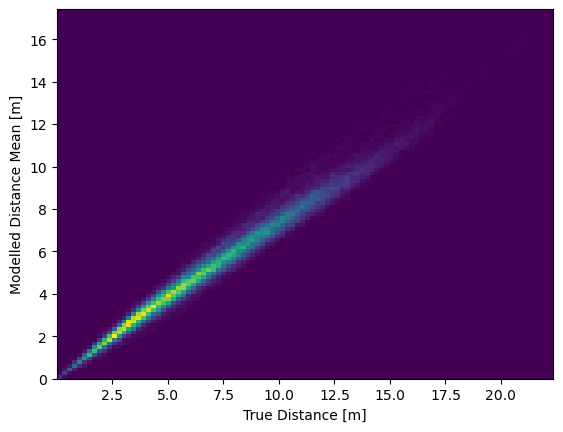

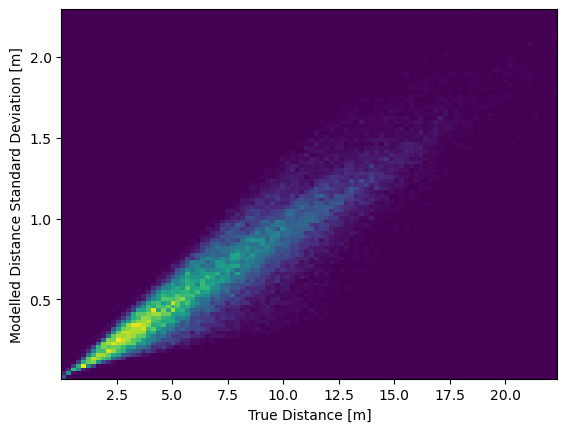

In [11]:
paths, path_hops, paths_d_mean, paths_d_variance = GDM.get_random_short_paths(50000)
groundtruth_distance_matrix = np.sqrt(np.sum((dichasus_cf0x.groundtruth_positions[:,np.newaxis,:] - dichasus_cf0x.groundtruth_positions[np.newaxis,:,:])**2, axis = -1))
groundtruth_dist = np.sum(groundtruth_distance_matrix[paths[:,:-1], paths[:,1:]], axis = 1).flatten()

plt.xlabel("True Distance [m]")
plt.ylabel("Modelled Distance Mean [m]")
plt.hist2d(groundtruth_dist, paths_d_mean, bins = 100)
plt.show()

plt.xlabel("True Distance [m]")
plt.ylabel("Modelled Distance Standard Deviation [m]")
plt.hist2d(groundtruth_dist, np.sqrt(paths_d_variance), bins = 100)
plt.show()

In [12]:
MIN_BATCH_SIZE = 2500
MAX_BATCH_SIZE = 3500
LEARNING_RATE_INITIAL = 2e-2
LEARNING_RATE_FINAL = 1e-2
MIN_PATHHOPS = 3
MAX_PATHHOPS = 8
TRAINING_BATCHES = 2000
ACCELERATION_MEAN = 0.8
ACCELERATION_VARIANCE = 1.7
ACCELERATION_WEIGHT = 0.04

#ACCELERATION_WEIGHT = 0.04 --> MAE = 0.9688
#ACCELERATION_WEIGHT = 0.00 --> MAE = 1.1641

# Now velocity_variance = 0.002 --> MAE = 0.7885m, wow! Lower velocity variance definitely better!
# ACCELERATION_WEIGHT = 0.04 --> MAE = 0.7114
# ACCELERATION_WEIGHT = 0.01 --> MAE = 0.7564
# ACCELERATION_WEIGHT = 0.02, MIN_PATHHOPS = 2, MAX_PATHHOPS = 4 --> MAE = 0.8343

# Now velocity_variance = 0.001
# ACCELERATION_WEIGHT = 0.04, MIN_PATHHOPS = 1, MAX_PATHHOPS = 10 --> MAE = 0.7101
# MAX_PATHHOPS = 5 --> MAE = 0.7650
# MAX_PATHHOPS = 20 --> MAE = 0.7869

# Now velocity_variance = 0.002
# MAX_PATHHOPS = 20 --> MAE = 0.943m
# MAX_PATHHOPS = 10, BATCH_SIZE = 4000 --> MAE = 0.898m
# MAX_PATHHOPS = 5, BATCH_SIZE = 4000, ACCELERATION_MEAN = 0.4 --> MAE = whatever, bad

# Now velocity_variance = 0.002, but NO PATH CONTRACTION
# MAX_PATHHOPS = 5, BATCH_SIZE = 3000, ACCELERATION_MEAN = 0.8 --> MAE = 0.6879
# MIN_PATHHOPS = 2, MAX_PATHHOPS = 4, BATCH_SIZE = 3000, ACCELERATION_MEAN = 0.8 --> MAE = 0.7440

# Now velocity_variance = 0.0015
# MIN_PATHHOPS = 1, MAX_PATHHOPS = 5, BATCH_SIZE = 3000, ACCELERATION_MEAN = 0.8 --> MAE = 0.6681

# Now velocity_variance = 0.0015, but number of path hops is random!
# MIN_PATHHOPS = 1, MAX_PATHHOPS = 10, BATCH_SIZE = 3000, ACCELERATION_MEAN = 0.8 --> MAE = 0.6385, wow!!!
# MIN_PATHHOPS = 1, MAX_PATHHOPS = 20, BATCH_SIZE = 3000, ACCELERATION_MEAN = 0.8 --> MAE = 0.7489
# MIN_PATHHOPS = 5, MAX_PATHHOPS = 10, BATCH_SIZE = 3000, ACCELERATION_MEAN = 0.8 --> MAE = 0.6716
# MIN_PATHHOPS = 3, MAX_PATHHOPS = 8, BATCH_SIZE = 3000, ACCELERATION_MEAN = 0.8 --> MAE = 0.6211, wow!!!
# MIN_PATHHOPS = 3, MAX_PATHHOPS = 8, LEARNING_RATE_INITIAL = 2e-2, LEARNING_RATE_FINAL = 4e-3 --> MAE = 0.6694
# MIN_PATHHOPS = 3, MAX_PATHHOPS = 8, LEARNING_RATE_INITIAL = 2e-2, LEARNING_RATE_FINAL = 1e-2 --> MAE = 0.6814
# same as above, but BATCH_SIZE = 6000 (instead of 3000) --> MAE = 0.8514

2024-10-11 14:12:22.432003: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-10-11 14:12:22.533108: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x5576ed396700 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-10-11 14:12:22.533167: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4080, Compute Capability 8.9
2024-10-11 14:12:22.541426: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-10-11 14:12:22.563211: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2024-10-11 14:12:22.666757: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the p

 199/2000 [=>............................] - ETA: 3:00 - loss: 16.1383 - metric: 0.0000e+00

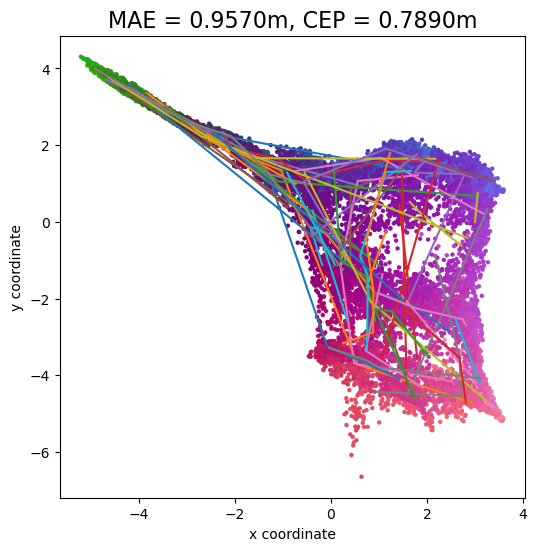

 399/2000 [====>.........................] - ETA: 2:42 - loss: 11.6875 - metric: 0.0000e+00

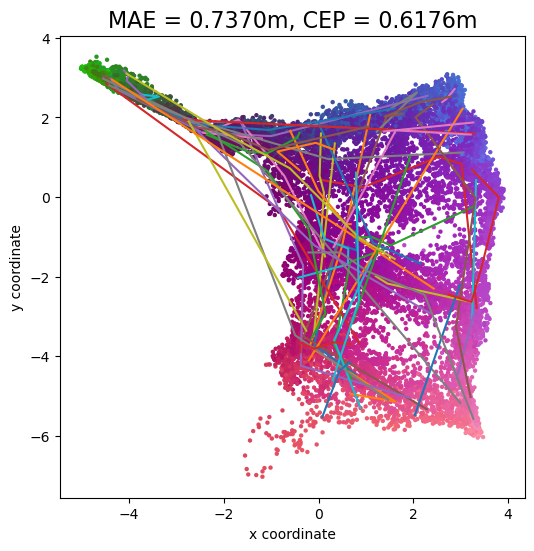

 599/2000 [=======>......................] - ETA: 2:23 - loss: 9.5943 - metric: 0.0000e+00

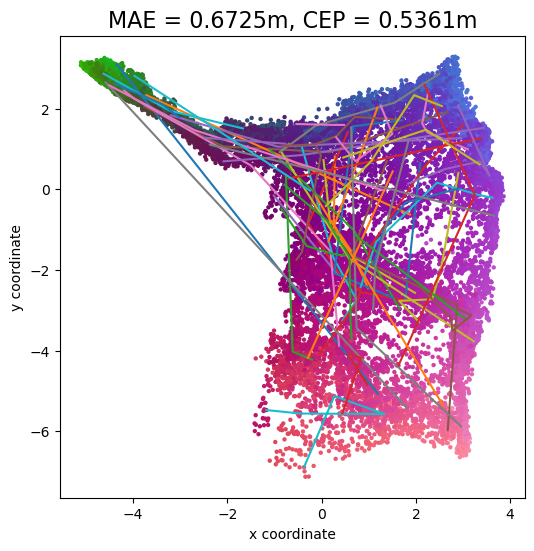

 799/2000 [==========>...................] - ETA: 2:06 - loss: 8.3783 - metric: 0.0000e+00

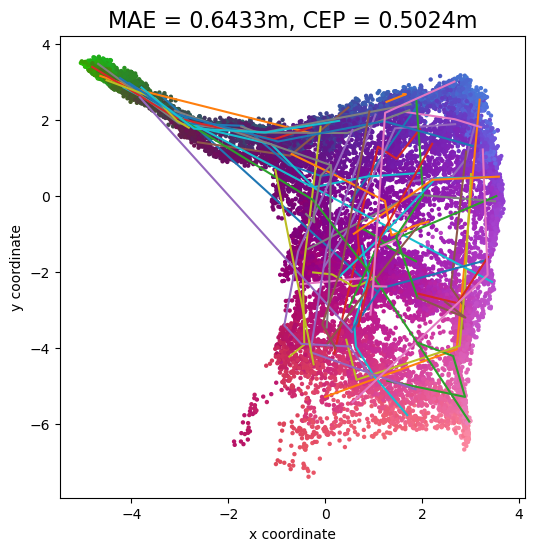

 999/2000 [=============>................] - ETA: 1:48 - loss: 7.4807 - metric: 0.0000e+00

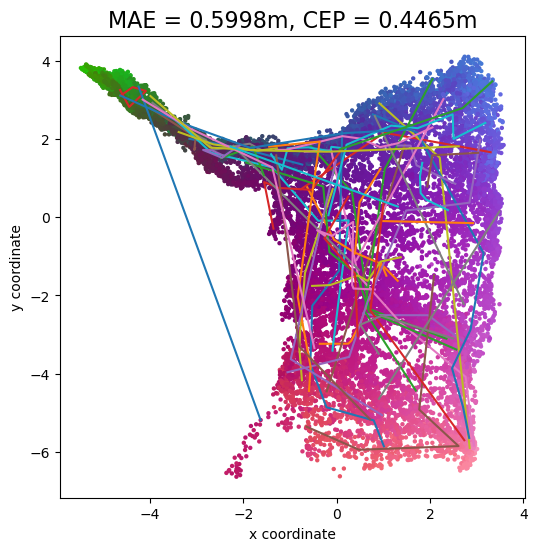

1199/2000 [================>.............] - ETA: 1:28 - loss: 6.8199 - metric: 0.0000e+00

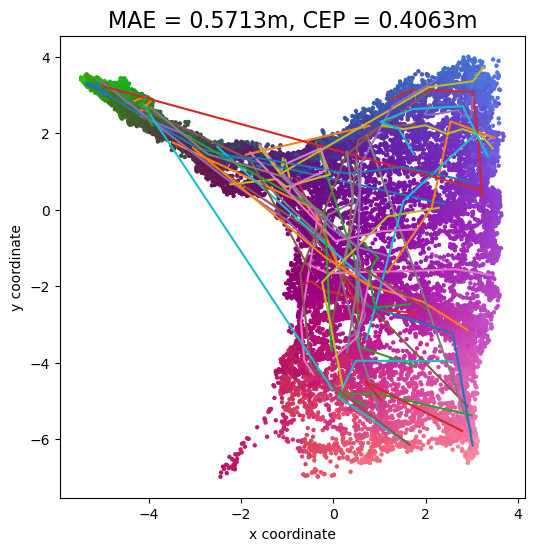

1399/2000 [===================>..........] - ETA: 1:07 - loss: 6.3163 - metric: 0.0000e+00

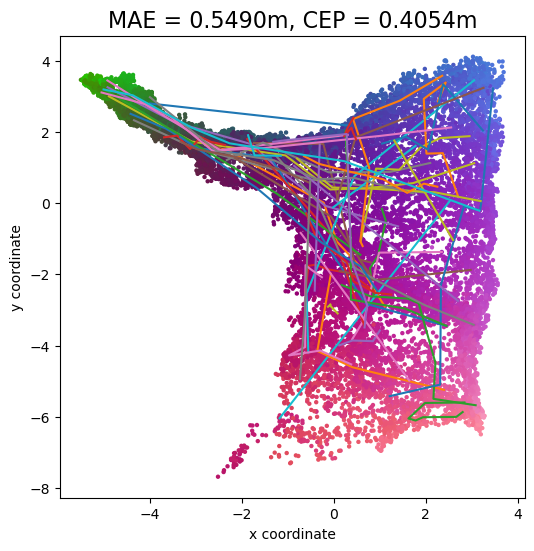

1599/2000 [======================>.......] - ETA: 46s - loss: 5.8451 - metric: 0.0000e+00

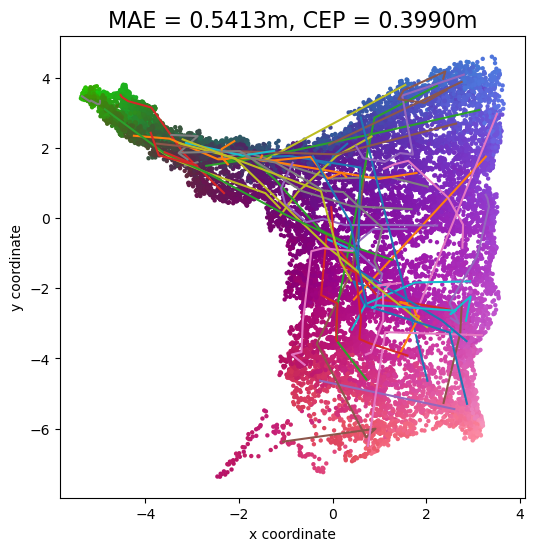

1799/2000 [=========================>....] - ETA: 23s - loss: 5.4456 - metric: 0.0000e+00

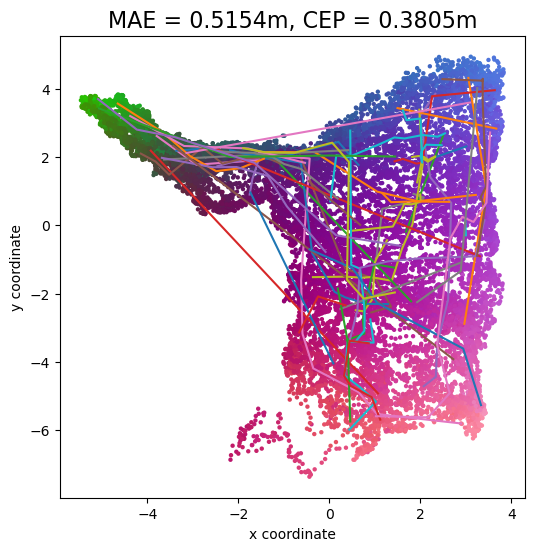

1999/2000 [============================>.] - ETA: 0s - loss: 5.1138 - metric: 0.0000e+00

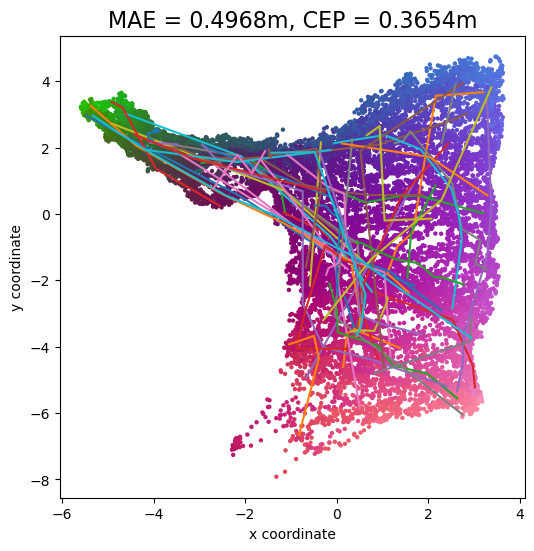

2000/2000 [==============================] - 245s 120ms/step - loss: 5.1123 - metric: 0.0000e+00


In [13]:
plot_callback = Evaluation.PlotChartCallback(dichasus_cf0x.groundtruth_positions, csi_time_domain_onearray.shape[0], MAX_PATHHOPS)
cc = ChannelChartingCore.ChannelChart(GDM, csi_time_domain_onearray, dichasus_cf0x.timestamps, min_batch_size = MIN_BATCH_SIZE, max_batch_size = MAX_BATCH_SIZE, learning_rate_initial = LEARNING_RATE_INITIAL, learning_rate_final = LEARNING_RATE_FINAL, min_pathhops = MIN_PATHHOPS, max_pathhops = MAX_PATHHOPS, randomize_pathhops = True, training_batches = TRAINING_BATCHES, plot_callback = plot_callback, acceleration_mean = ACCELERATION_MEAN, acceleration_variance = ACCELERATION_VARIANCE, acceleration_weight = ACCELERATION_WEIGHT)

In [14]:
channel_chart_positions = cc.predict(csi_time_domain_onearray)

652/652 [==============================] - 1s 2ms/step


In [15]:
ct, tw, ks = Evaluation.ct_tw_ks_on_subset(dichasus_cf0x.groundtruth_positions, channel_chart_positions)
print(f"CT: {ct:.4f}\nTW: {tw:.4f}\nKS: {ks:.4f}")

CT: 0.9928
TW: 0.9916
KS: 0.1196


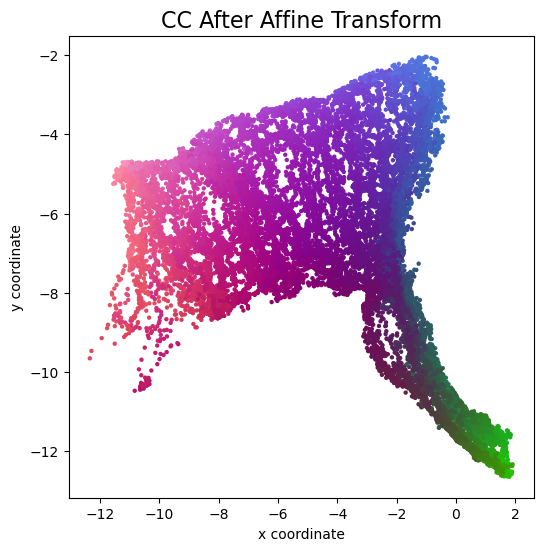

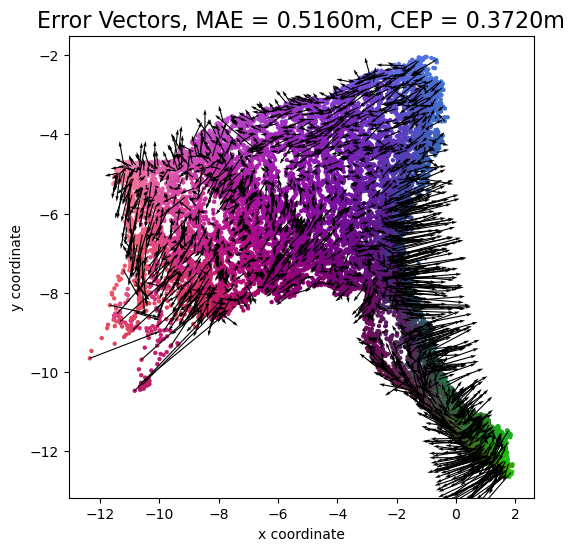

In [16]:
channel_chart_positions_transformed, errorvectors, errors, mae, cep = Evaluation.mean_absolute_error_transformed(dichasus_cf0x.groundtruth_positions, channel_chart_positions)
Evaluation.plot_colorized(channel_chart_positions_transformed, dichasus_cf0x.groundtruth_positions, title = "CC After Affine Transform")

nth_errorvector = 10
Evaluation.plot_colorized(channel_chart_positions_transformed, dichasus_cf0x.groundtruth_positions, title = f"Error Vectors, MAE = {mae:.4f}m, CEP = {cep:.4f}m", show = False)
plt.quiver(channel_chart_positions_transformed[::nth_errorvector, 0], channel_chart_positions_transformed[::nth_errorvector, 1], errorvectors[::nth_errorvector, 0], errorvectors[::nth_errorvector, 1], color = "black", angles = "xy", scale_units = "xy", scale = 1)
plt.show()

### Evaluate on Test set

In [17]:
test_set_groundtruth_positions = []
test_set_csi_time_domain = []

for csi, pos, time in dichasus_cf0x.dichasus_cf0x_testset.batch(1000):
    test_set_csi_time_domain.append(csi.numpy())
    test_set_groundtruth_positions.append(pos.numpy())

test_set_csi_time_domain = np.concatenate(test_set_csi_time_domain)
test_set_groundtruth_positions = np.concatenate(test_set_groundtruth_positions)

In [18]:
# Remove CSI from all antenna arrays except array b=2
test_set_csi_time_domain = test_set_csi_time_domain[:,1][:,np.newaxis]

In [19]:
test_set_channel_chart_positions = cc.predict(test_set_csi_time_domain)

652/652 [==============================] - 1s 2ms/step


In [20]:
ts_ct, ts_tw, ts_ks = Evaluation.ct_tw_ks_on_subset(test_set_groundtruth_positions, test_set_channel_chart_positions)
print(f"CT: {ts_ct:.4f}\nTW: {ts_tw:.4f}\nKS: {ts_ks:.4f}")

CT: 0.9920
TW: 0.9915
KS: 0.1171


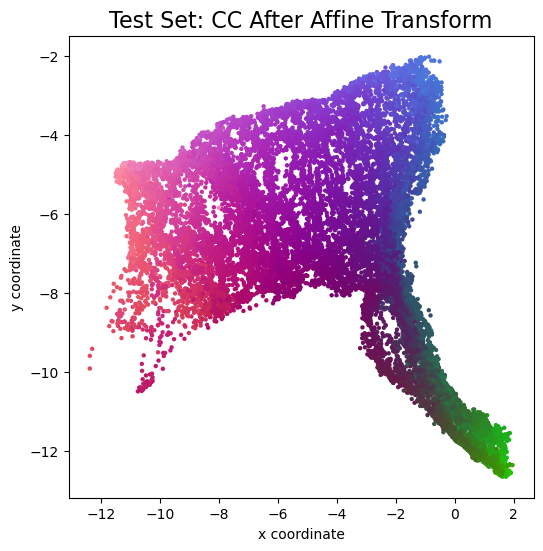

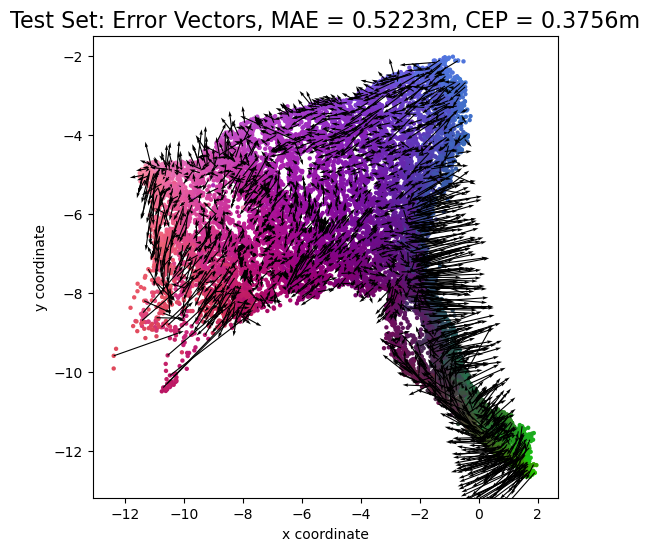

In [21]:
test_set_channel_chart_positions_transformed, ts_errorvectors, ts_errors, ts_mae, ts_cep = Evaluation.mean_absolute_error_transformed(test_set_groundtruth_positions, test_set_channel_chart_positions)
Evaluation.plot_colorized(test_set_channel_chart_positions_transformed, test_set_groundtruth_positions, title = "Test Set: CC After Affine Transform")

nth_errorvector = 10
Evaluation.plot_colorized(test_set_channel_chart_positions_transformed, test_set_groundtruth_positions, title = f"Test Set: Error Vectors, MAE = {ts_mae:.4f}m, CEP = {ts_cep:.4f}m", show = False)
plt.quiver(test_set_channel_chart_positions_transformed[::nth_errorvector, 0], test_set_channel_chart_positions_transformed[::nth_errorvector, 1], ts_errorvectors[::nth_errorvector, 0], ts_errorvectors[::nth_errorvector, 1], color = "black", angles = "xy", scale_units = "xy", scale = 1)
plt.show()